# Droplet segmentation

In [1]:
from functools import partial
from multiprocessing import Pool
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.color import label2rgb
from skimage.draw import disk
from skimage.filters import threshold_multiotsu
from tifffile import imread, imwrite
from tqdm.auto import tqdm

from droplet_segmentation_tasks import get_droplets

In [2]:
%matplotlib widget
img_dir = "../data/img"
mask_dir = "../data/masks"
img_info_file = "../data/images.csv"
droplets_file = "../data/droplets.csv"
filtered_droplets_file = "../data/droplets_highaccum.csv"

## Image loading

In [3]:
img_files = sorted(Path(img_dir).glob("*.tiff"))
raw_img_list = [imread(img_file) for img_file in tqdm(img_files)]  # shape: (n, t, y, x)
n = len(raw_img_list)

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
img_info = pd.DataFrame(
    data=[
        {
            "image": img_file.name,
            "image_width": raw_img.shape[-1],
            "image_height": raw_img.shape[-2],
        }
        for img_file, raw_img in zip(img_files, raw_img_list)
    ]
)
img_info.to_csv(img_info_file, index=False)
img_info

,image,image_width,image_height
0,10 to 5 e coli with cefotaxine 1 point 5_15.tiff,2048,2048
1,Droplets with 10 to 4 e coli_01.tiff,2048,2048
2,Resistant e coli with 10 to 5 with 1.5 mg per ...,2048,2048
3,droplet with 10 to 5 e coli_001.tiff,2048,2048


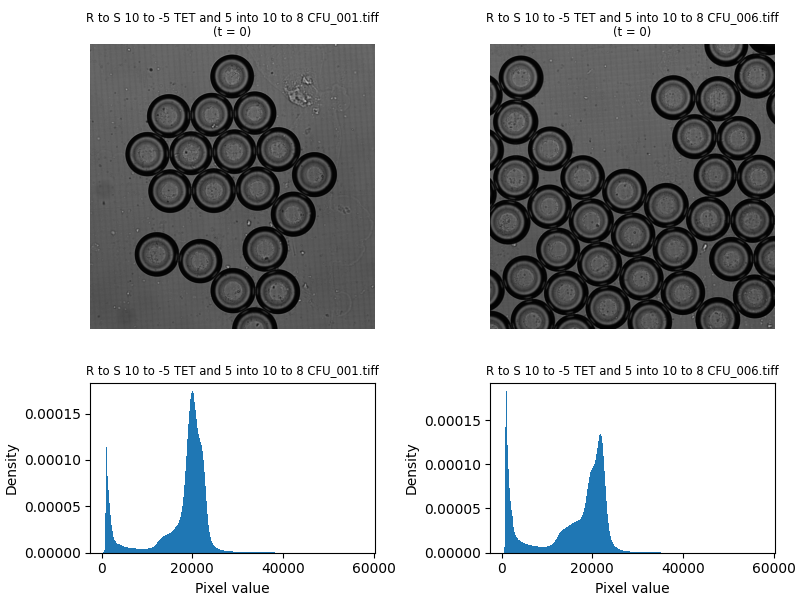

In [5]:
t = 0
vmin = min(np.amin(raw_img) for raw_img in raw_img_list)
vmax = max(np.amax(raw_img) for raw_img in raw_img_list)
fig, axs = plt.subplots(
    nrows=2, ncols=n, height_ratios=(2, 1), figsize=(4 * n, 6), constrained_layout=True
)
for img_file, raw_img, (ax1, ax2) in zip(img_files, raw_img_list, axs.transpose()):
    ax1.set_title(f"{img_file.name}\n(t = {t})", fontsize="small")
    ax1.imshow(raw_img[t], cmap="gray", vmin=vmin, vmax=vmax)
    ax1.set_axis_off()
    ax2.set_title(f"{img_file.name}", fontsize="small")
    ax2.hist(raw_img.flatten(), bins=256, range=(vmin, vmax), density=True)
    ax2.set_xlabel("Pixel value")
    ax2.set_ylabel("Density")
plt.show()

## Image preprocessing
1. Gaussian smoothing to remove artifacts
2. Grayscale opening to fill holes in circles
3. Min-max normalization for visualization
4. Conversion to unsigned 8-bit integer range

In [6]:
gaussian_sigma = 5
opening_radius = 10

In [7]:
gaussian_ksize = (6 * gaussian_sigma + 1, 6 * gaussian_sigma + 1)
opening_ksize = (2 * opening_radius + 1, 2 * opening_radius + 1)
opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, opening_ksize)
img_list = [
    cv2.normalize(
        np.array(
            [
                cv2.morphologyEx(
                    cv2.GaussianBlur(raw_img_t, gaussian_ksize, gaussian_sigma),
                    cv2.MORPH_OPEN,
                    opening_kernel,
                )
                for raw_img_t in raw_img
            ]
        ),
        None,
        0,
        255,
        cv2.NORM_MINMAX,
    ).astype(np.uint8)
    for raw_img in tqdm(raw_img_list)
]  # shape: (n, t, y, x)

  0%|          | 0/2 [00:00<?, ?it/s]

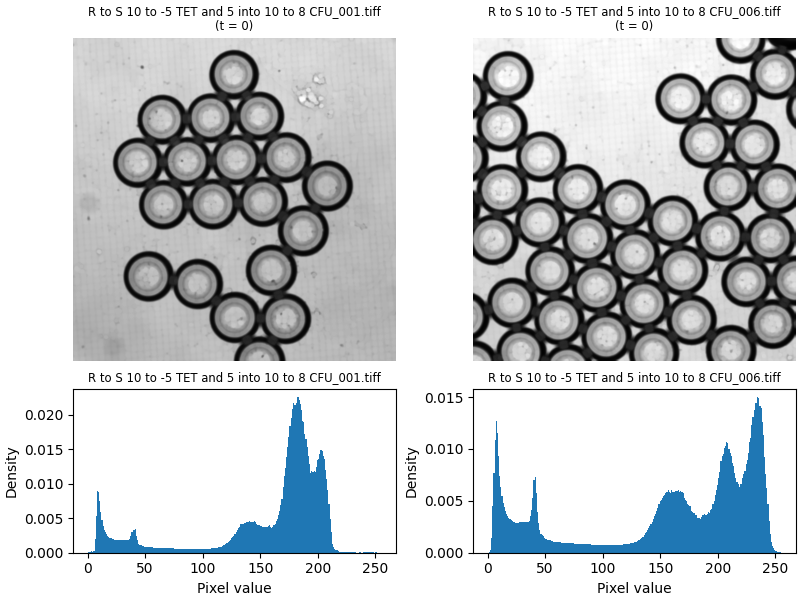

In [8]:
t = 0
fig, axs = plt.subplots(
    nrows=2, ncols=n, height_ratios=(2, 1), figsize=(4 * n, 6), constrained_layout=True
)
for img_file, img, (ax1, ax2) in zip(img_files, img_list, axs.transpose()):
    ax1.set_title(f"{img_file.name}\n(t = {t})", fontsize="small")
    ax1.imshow(img[t], cmap="gray", vmin=0, vmax=255)
    ax1.set_axis_off()
    ax2.set_title(f"{img_file.name}", fontsize="small")
    ax2.hist(img.flatten(), bins=256, range=(0, 255), density=True)
    ax2.set_xlabel("Pixel value")
    ax2.set_ylabel("Density")
plt.show()

## Circle thresholding
Three-class (outer circles, inner circles/other droplet content, background) Otsu thresholding to mask circles

In [9]:
thresholds_list = [
    threshold_multiotsu(img, classes=3) for img in tqdm(img_list)
]  # shape: (n, 2)
edges_list = [
    np.where(img < thresholds[0], 255, 0).astype(np.uint8)
    for img, thresholds in zip(img_list, thresholds_list)
]  # shape: (n, t, y, x)

  0%|          | 0/2 [00:00<?, ?it/s]

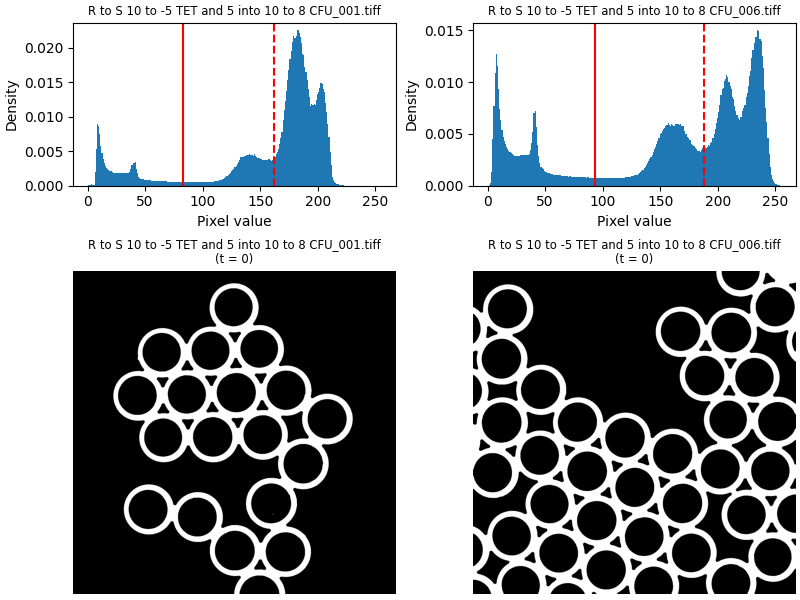

In [10]:
t = 0
fig, axs = plt.subplots(
    nrows=2, ncols=n, height_ratios=(1, 2), figsize=(4 * n, 6), constrained_layout=True
)
for img_file, img, edges, thresholds, (ax1, ax2) in zip(
    img_files, img_list, edges_list, thresholds_list, axs.transpose()
):
    ax1.set_title(img_file.name, fontsize="small")
    ax1.hist(img.flatten(), bins=256, range=(0, 255), density=True)
    ax1.axvline(thresholds[0], color="red")
    for threshold in thresholds[1:]:
        ax1.axvline(threshold, color="red", linestyle="--")
    ax1.set_xlabel("Pixel value")
    ax1.set_ylabel("Density")
    ax2.set_title(f"{img_file.name}\n(t = {t})", fontsize="small")
    ax2.imshow(edges[t], cmap="gray")
    ax2.set_axis_off()
plt.show()

## Droplet detection
Circle Hough transform on circles to detect droplets

In [11]:
hough_min_radius = 125
hough_max_radius = 175
hough_radius_step = 5
hough_min_distance = 200

In [12]:
%%time
f = partial(
    get_droplets,
    hough_min_radius=hough_min_radius,
    hough_max_radius=hough_max_radius,
    hough_radius_step=hough_radius_step,
    hough_min_distance=hough_min_distance,
)
with Pool() as pool:
    droplets_lists = [
        pool.map(f, edges) for edges in tqdm(edges_list)
    ]  # shape: (n, t, c, 4)

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: total: 328 ms
Wall time: 1min 35s


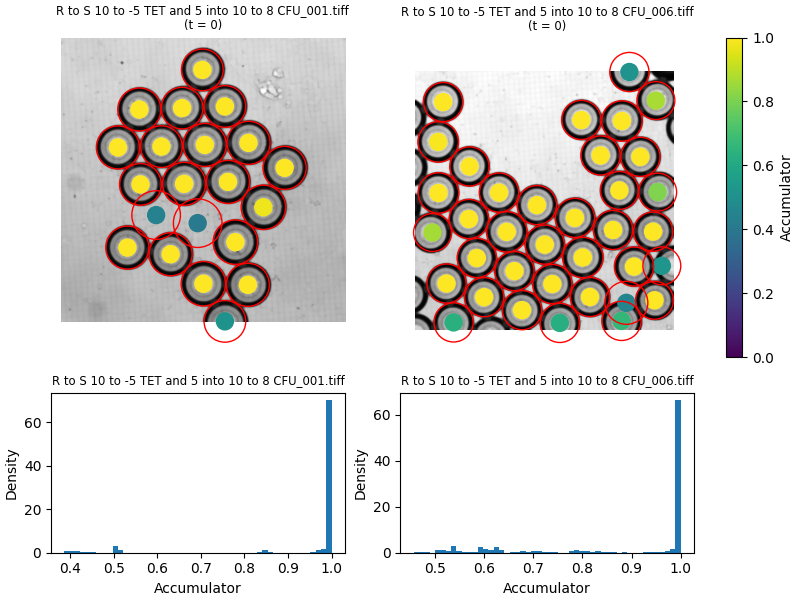

In [13]:
t = 0
fig, axs = plt.subplots(
    nrows=2, ncols=n, height_ratios=(2, 1), figsize=(4 * n, 6), constrained_layout=True
)
for img_file, img, droplets_list, (ax1, ax2) in zip(
    img_files, img_list, droplets_lists, axs.transpose()
):
    ax1.set_title(f"{img_file.name}\n(t = {t})", fontsize="small")
    ax1.imshow(img[t], cmap="gray", vmin=0, vmax=255)
    last_scatter = ax1.scatter(
        droplets_list[t][:, 1],
        droplets_list[t][:, 2],
        s=150,
        c=droplets_list[t][:, 0],
        vmin=0,
        vmax=1,
    )
    for accum, cx, cy, radius in droplets_list[t]:
        ax1.add_patch(plt.Circle((cx, cy), radius=radius, color="red", fill=False))
    ax1.set_axis_off()
    ax2.set_title(img_file.name, fontsize="small")
    ax2.hist(
        np.concatenate([droplets[:, 0] for droplets in droplets_list]),
        bins=50,
        range=(-0.001, 1.001),
        density=True,
    )
    ax2.set_xlabel("Accumulator")
    ax2.set_ylabel("Density")
plt.colorbar(last_scatter, ax=axs[0].tolist(), label="Accumulator")
plt.show()

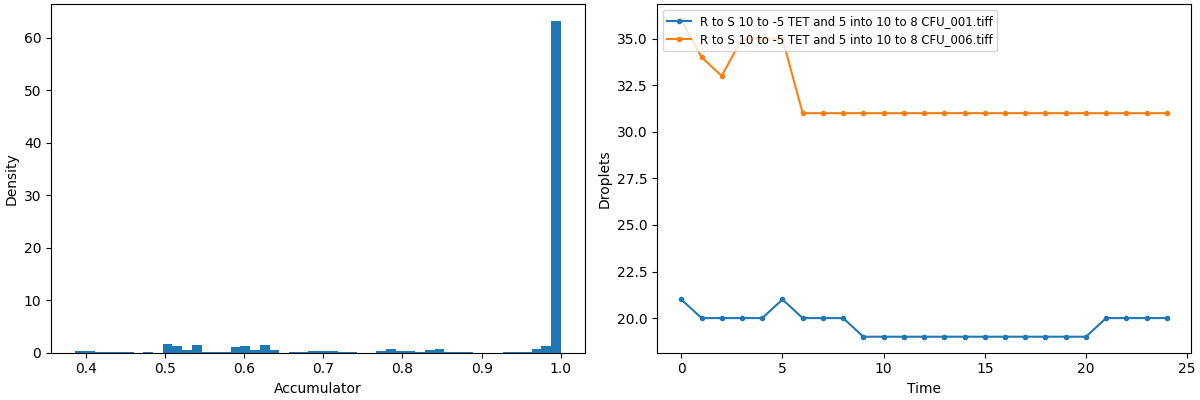

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4), constrained_layout=True)
ax1.hist(
    np.concatenate(
        [
            droplets[:, 0]
            for droplets_list in droplets_lists
            for droplets in droplets_list
        ]
    ),
    bins=50,
    density=True,
)
ax1.set_xlabel("Accumulator")
ax1.set_ylabel("Density")
for img_file, droplets_list in zip(img_files, droplets_lists):
    droplet_counts = np.array([len(droplets) for droplets in droplets_list])
    ax2.plot(droplet_counts, label=img_file.name, linestyle="-", marker=".")
ax2.legend(loc="upper left", fontsize="small")
ax2.set_xlabel("Time")
ax2.set_ylabel("Droplets")
plt.show()

## Droplet filtering
Thresholding of normalized Hough accumulator score to filter droplets

In [15]:
min_accum = 0.8

In [16]:
filtered_droplets_lists = [
    [droplets[droplets[:, 0] >= min_accum, :] for droplets in droplets_list]
    for droplets_list in droplets_lists
]  # shape: (n, t, c, 4)

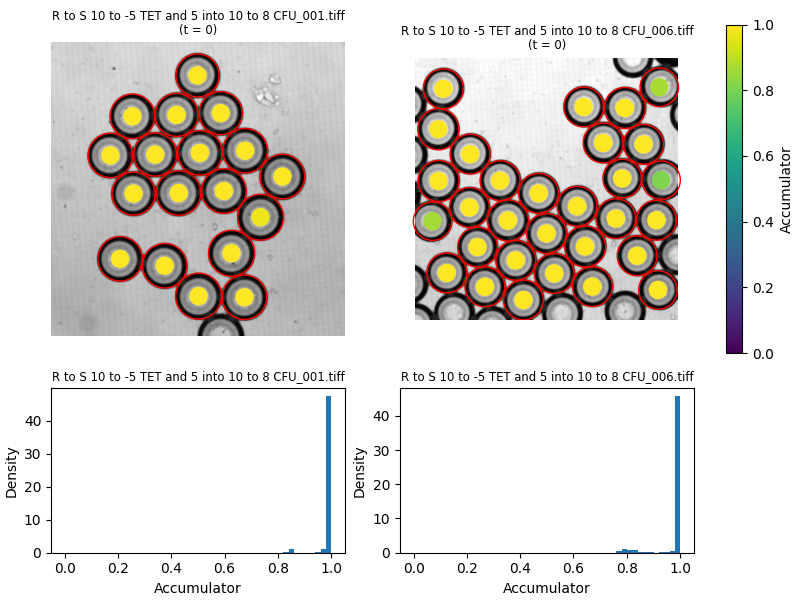

In [17]:
t = 0
fig, axs = plt.subplots(
    nrows=2, ncols=n, height_ratios=(2, 1), figsize=(4 * n, 6), constrained_layout=True
)
for img_file, img, filtered_droplets_list, (ax1, ax2) in zip(
    img_files, img_list, filtered_droplets_lists, axs.transpose()
):
    ax1.set_title(f"{img_file.name}\n(t = {t})", fontsize="small")
    ax1.imshow(img[t], cmap="gray", vmin=0, vmax=255)
    last_scatter = ax1.scatter(
        filtered_droplets_list[t][:, 1],
        filtered_droplets_list[t][:, 2],
        s=150,
        c=filtered_droplets_list[t][:, 0],
        vmin=0,
        vmax=1,
    )
    for accum, cx, cy, radius in filtered_droplets_list[t]:
        ax1.add_patch(plt.Circle((cx, cy), radius=radius, color="red", fill=False))
    ax1.set_axis_off()
    ax2.set_title(img_file.name, fontsize="small")
    ax2.hist(
        np.concatenate(
            [filtered_droplets[:, 0] for filtered_droplets in filtered_droplets_list]
        ),
        bins=50,
        range=(-0.001, 1.001),
        density=True,
    )
    ax2.set_xlabel("Accumulator")
    ax2.set_ylabel("Density")
plt.colorbar(last_scatter, ax=axs[0].tolist(), label="Accumulator")
plt.show()

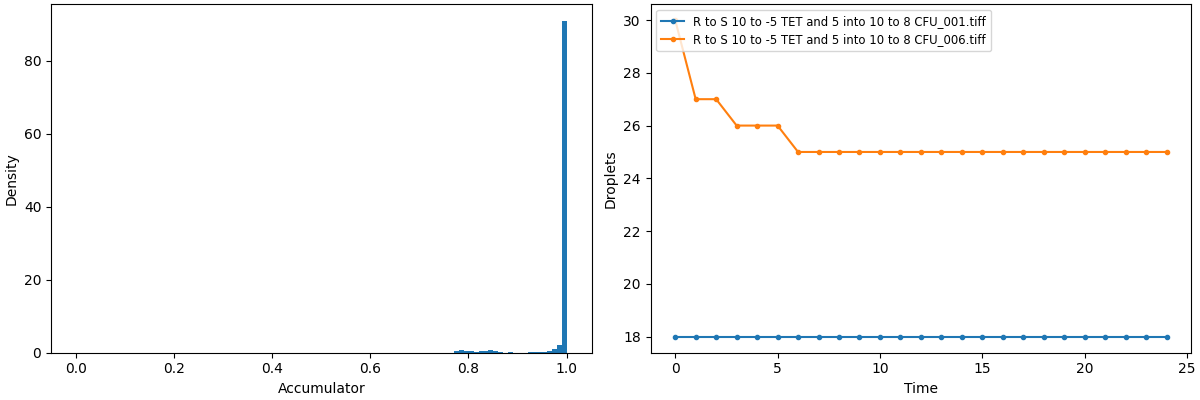

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4), constrained_layout=True)
ax1.hist(
    np.concatenate(
        [
            filtered_droplets[:, 0]
            for filtered_droplets_list in filtered_droplets_lists
            for filtered_droplets in filtered_droplets_list
        ]
    ),
    bins=100,
    range=(-0.001, 1.001),
    density=True,
)
ax1.set_xlabel("Accumulator")
ax1.set_ylabel("Density")
for img_file, filtered_droplets_list in zip(img_files, filtered_droplets_lists):
    filtered_droplet_counts = np.array(
        [len(filtered_droplets) for filtered_droplets in filtered_droplets_list]
    )
    ax2.plot(filtered_droplet_counts, label=img_file.name, linestyle="-", marker=".")
ax2.legend(loc="upper left", fontsize="small")
ax2.set_xlabel("Time")
ax2.set_ylabel("Droplets")
plt.show()

## Table generation

In [19]:
df = pd.concat(
    {
        (img_file.name, t): pd.DataFrame(
            data=droplets,
            columns=["accum", "center_x", "center_y", "radius"],
            index=pd.RangeIndex(start=1, stop=len(droplets) + 1, name="index"),
        )
        for img_file, droplets_list in zip(img_files, droplets_lists)
        for t, droplets in enumerate(droplets_list)
    },
    names=["image", "time", "droplet"],
).reset_index()
df.to_csv(droplets_file, index=False)
df

,image,time,droplet,accum,center_x,center_y,radius
0,10 to 5 e coli with cefotaxine 1 point 5_15.tiff,0,1,1.000000,376.0,638.0,145.0
1,10 to 5 e coli with cefotaxine 1 point 5_15.tiff,0,2,1.000000,270.0,1465.0,160.0
2,10 to 5 e coli with cefotaxine 1 point 5_15.tiff,0,3,1.000000,1413.0,1546.0,160.0
3,10 to 5 e coli with cefotaxine 1 point 5_15.tiff,0,4,1.000000,250.0,1793.0,160.0
4,10 to 5 e coli with cefotaxine 1 point 5_15.tiff,0,5,1.000000,1383.0,1873.0,160.0
...,...,...,...,...,...,...,...
3686,droplet with 10 to 5 e coli_001.tiff,20,51,0.573034,1144.0,2022.0,125.0
3687,droplet with 10 to 5 e coli_001.tiff,20,52,0.545455,19.0,1656.0,155.0
3688,droplet with 10 to 5 e coli_001.tiff,20,53,0.533708,1871.0,1910.0,125.0
3689,droplet with 10 to 5 e coli_001.tiff,20,54,0.473790,1404.0,243.0,175.0


In [20]:
df_filtered = pd.concat(
    {
        (img_file.name, t): pd.DataFrame(
            data=filtered_droplets,
            columns=["accum", "center_x", "center_y", "radius"],
            index=pd.RangeIndex(start=1, stop=len(filtered_droplets) + 1, name="index"),
        )
        for img_file, filtered_droplets_list in zip(img_files, filtered_droplets_lists)
        for t, filtered_droplets in enumerate(filtered_droplets_list)
    },
    names=["image", "time", "droplet"],
).reset_index()
df_filtered.to_csv(filtered_droplets_file, index=False)
df_filtered

,image,time,droplet,accum,center_x,center_y,radius
0,10 to 5 e coli with cefotaxine 1 point 5_15.tiff,0,1,1.000000,376.0,638.0,145.0
1,10 to 5 e coli with cefotaxine 1 point 5_15.tiff,0,2,1.000000,270.0,1465.0,160.0
2,10 to 5 e coli with cefotaxine 1 point 5_15.tiff,0,3,1.000000,1413.0,1546.0,160.0
3,10 to 5 e coli with cefotaxine 1 point 5_15.tiff,0,4,1.000000,250.0,1793.0,160.0
4,10 to 5 e coli with cefotaxine 1 point 5_15.tiff,0,5,1.000000,1383.0,1873.0,160.0
...,...,...,...,...,...,...,...
2871,droplet with 10 to 5 e coli_001.tiff,20,38,0.862903,1927.0,922.0,130.0
2872,droplet with 10 to 5 e coli_001.tiff,20,39,0.850000,1516.0,685.0,140.0
2873,droplet with 10 to 5 e coli_001.tiff,20,40,0.834677,283.0,313.0,130.0
2874,droplet with 10 to 5 e coli_001.tiff,20,41,0.820000,1428.0,948.0,140.0


## Mask generation

In [21]:
mask_list = []
Path(mask_dir).mkdir(exist_ok=True)
for img_file, img, filtered_droplets_list in zip(
    img_files, img_list, filtered_droplets_lists
):
    mask = np.zeros_like(img, dtype=np.uint16)
    for i, filtered_droplets in enumerate(filtered_droplets_list):
        sorted_droplets = filtered_droplets[np.argsort(filtered_droplets[:, 0])]
        for droplet_id, (accum, cx, cy, radius) in enumerate(sorted_droplets, start=1):
            rr, cc = disk((cy, cx), radius, shape=mask[i].shape)
            mask[i, rr, cc] = droplet_id
    mask_list.append(mask)
    imwrite(Path(mask_dir) / img_file.name, mask)

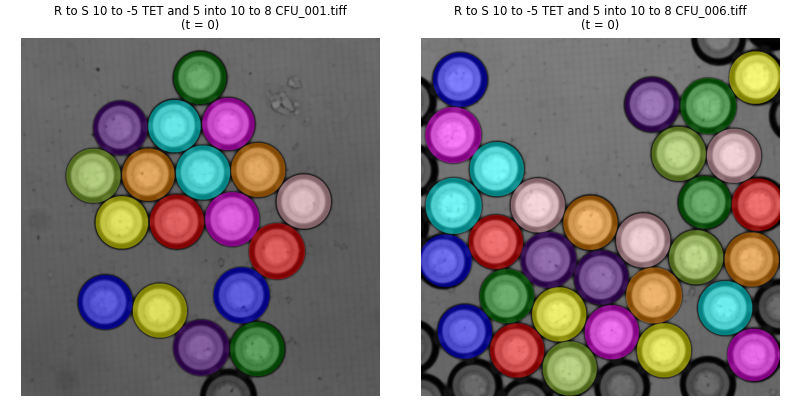

In [24]:
t = 0
fig, axs = plt.subplots(ncols=n, figsize=(4 * n, 4), constrained_layout=True)
for img_file, img, mask, ax in zip(img_files, img_list, mask_list, axs):
    ax.set_title(f"{img_file.name}\n(t = {t})", fontsize="small")
    ax.imshow(label2rgb(mask[t], image=img[t], alpha=0.5))
    ax.set_axis_off()
plt.show()

## Border detection

In [ ]:
extra_margin = 0

In [ ]:
for file_path in [Path(droplets_file), Path(filtered_droplets_file)]:
    df = pd.read_csv(file_path).merge(pd.read_csv(img_info_file), on="image")
    radius = df["radius"].median() + extra_margin
    df = df[
        (df["center_x"] - radius >= 0)
        & (df["center_y"] - radius >= 0)
        & (df["center_x"] + radius < df["image_width"])
        & (df["center_y"] + radius < df["image_height"])
    ]
    df.to_csv(file_path.with_stem(file_path.stem + "_noborder"), index=False)

## Notes

Other approaches/failed attempts:
- Edge detection instead of thresholding: inner/outer radii vary with circle thickness
- Contour detection + ellipse fitting instead of Hough transform: thinning yields connected contours
- Learning-based segmentation using Ilastik: random forests fail to discriminate droplet and background classes

In [ ]:
# labels_list = []
# for edges, filtered_droplets_list in zip(edges_list, filtered_droplets_lists):
#     labels = np.zeros_like(edges, dtype=np.uint8)
#     for t, filtered_droplets in enumerate(filtered_droplets_list):
#         mask = edges[t] != 0
#         markers = np.zeros_like(edges[t], dtype=np.uint8)
#         for i, (accum, cx, cy, radius) in enumerate(filtered_droplets):
#             rr, cc = disk((cy, cx), radius, shape=mask.shape)
#             mask[rr, cc] = True
#             markers[int(cy), int(cx)] = i + 1
#         dists = distance_transform_edt(edges[t] == 0)
#         labels[t] = watershed(-dists, markers=markers, mask=mask)
#     labels_list.append(labels)

In [ ]:
# min_ellipse_area = 30000
# max_ellipse_eccentricity = 0.7
# max_ellipse_match_difference = 0.05

# ellipse_areas = []
# ellipse_eccentricities = []
# ellipse_match_differences = []
# masks = np.zeros_like(thres_imgs8, dtype=np.uint16)
# for i, thres_img8 in enumerate(tqdm(thres_imgs8)):
#     contours, hierarchy = cv2.findContours(
#         thres_img8, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
#     )
#     next_label = int(np.max(masks[i])) + 1
#     for j, (contour, h) in enumerate(zip(contours, hierarchy[0])):
#         h_next, h_previous, h_child, h_parent = h
#         if h_parent >= 0 and len(contour) >= 5:
#             (cx, cy), (a, b), angle = cv2.fitEllipse(contour)
#             if a > 0 and b > 0:
#                 assert a <= b
#                 ellipse_area = 0.25 * np.pi * a * b
#                 ellipse_eccentricity = (1 - (a / b) ** 2) ** 0.5
#                 ellipse_contour = cv2.ellipse2Poly(
#                     (int(cx), int(cy)), (int(a), int(b)), int(angle), 0, 360, 1
#                 )
#                 ellipse_match_difference = cv2.matchShapes(
#                     contour, ellipse_contour, cv2.CONTOURS_MATCH_I1, 0.0
#                 )
#                 if (
#                     ellipse_area >= min_ellipse_area
#                     and ellipse_eccentricity <= max_ellipse_eccentricity
#                     and ellipse_match_difference <= max_ellipse_match_difference
#                 ):
#                     masks[i] = cv2.drawContours(
#                         masks[i], contours, j, next_label, thickness=cv2.FILLED
#                     )
#                     next_label += 1
#                 ellipse_areas.append(ellipse_area)
#                 ellipse_eccentricities.append(ellipse_eccentricity)
#                 ellipse_match_differences.append(ellipse_match_difference)
# ellipse_areas = np.array(ellipse_areas)
# ellipse_eccentricities = np.array(ellipse_eccentricities)
# ellipse_match_differences = np.array(ellipse_match_differences)

# t = 0
# plt.figure("Mask")
# plt.title(f"t = {t}")
# plt.imshow(masks[t], cmap="gray")
# plt.axis("off")
# plt.show()

# m1 = ellipse_areas >= min_ellipse_area
# m2 = ellipse_eccentricities <= max_ellipse_eccentricity
# m3 = ellipse_match_differences <= max_ellipse_match_difference

# fig, (ax1, ax2, ax3) = plt.subplots(
#     nrows=1,
#     ncols=3,
#     figsize=(
#         3 * plt.rcParams["figure.figsize"][0],
#         plt.rcParams["figure.figsize"][1],
#     ),
# )
# fig.suptitle("Ellipses")

# ax1.hist(
#     ellipse_areas[m2 & m3], bins=50, range=(0, 50000), density=True, color="gray"
# )
# ax1.axvline(min_ellipse_area, color="blue")
# ax1.set_xlabel("Area")
# ax1.set_ylabel("Density")

# ax2.hist(
#     ellipse_eccentricities[m1 & m3], bins=50, range=(0, 1), density=True, color="gray"
# )
# ax2.axvline(max_ellipse_eccentricity, color="blue")
# ax2.set_xlabel("Eccentricity")
# ax2.set_ylabel("Density")

# ax3.hist(
#     ellipse_match_differences[m1 & m2],
#     bins=100,
#     range=(0, 0.1),
#     density=True,
#     color="gray",
# )
# ax3.axvline(max_ellipse_match_difference, color="blue")
# ax3.set_xlabel("Match difference")
# ax3.set_ylabel("Density")

# plt.show()